In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torchvision import transforms
import plotly.express as px
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

BATCH_SIZE = 256
LEARNING_RATE = 10**-6
# PATH_TO_TRAINING_IMAGES = '/content/data/train_images'
# PATH_TO_TRAINING_DATA =  '/content/data/train.csv'
# PATH_TO_TEST_IMAGES = '/content/data/test_images'
# PATH_TO_TEST_DATA = '/content/data/test.csv'

# PATH_TO_TRAINING_IMAGES = '/Users/glennjoseph/Desktop/CS480/project/data/train_images'
# PATH_TO_TRAINING_DATA =  '/Users/glennjoseph/Desktop/CS480/project/data/train.csv'
# PATH_TO_TEST_IMAGES = '/Users/glennjoseph/Desktop/CS480/project/data/test_images'
# PATH_TO_TEST_DATA = '/Users/glennjoseph/Desktop/CS480/project/data/test.csv'

PATH_TO_TRAINING_IMAGES = r'C:\Users\annkj\Desktop\ML\cs-480-data\data\train_images'
PATH_TO_TRAINING_DATA =  r'C:\Users\annkj\Desktop\ML\cs-480-data\data\train.csv'
PATH_TO_TEST_IMAGES = r'C:\Users\annkj\Desktop\ML\cs-480-data\data\test_images'
PATH_TO_TEST_DATA = r'C:\Users\annkj\Desktop\ML\cs-480-data\data\test.csv'
PATH_TO_MODEL = r'C:\Users\annkj\Desktop\ML\Models'
PATH_TO_OUTPUT_CSV = r'C:\Users\annkj\Desktop\ML'
LOG_EPSILON = 1e-10
N_PCA_COMPONENTS = 19
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Data And Scale Init

In [49]:
original_training_data = pd.read_csv(PATH_TO_TRAINING_DATA)
original_testing_data = pd.read_csv(PATH_TO_TEST_DATA)
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(0,1))

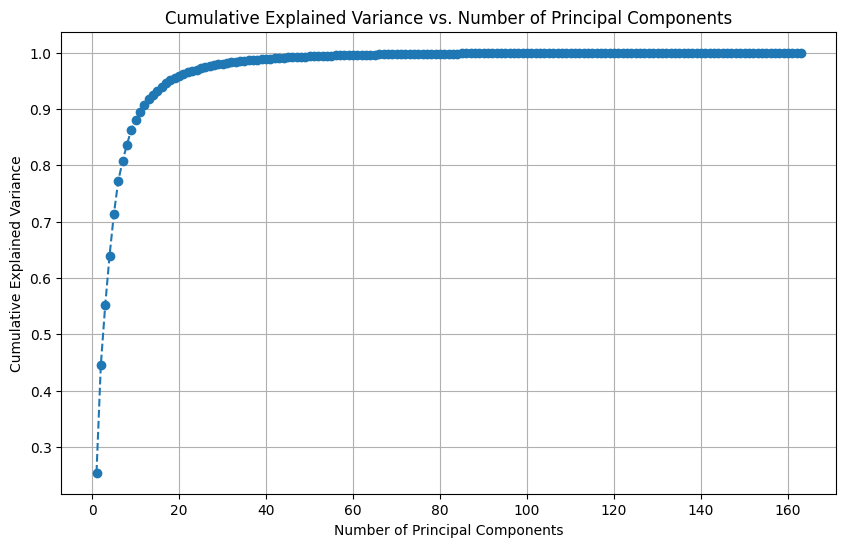

Number of components to retain 95.0% variance: 18
Reduced data shape: (6391, 18)
Important features for PC1:
VOD_C_2002_2018_multiyear_mean_m11                                       0.141969
VOD_C_2002_2018_multiyear_mean_m12                                       0.141636
VOD_X_1997_2018_multiyear_mean_m11                                       0.141326
VOD_C_2002_2018_multiyear_mean_m10                                       0.140367
VOD_C_2002_2018_multiyear_mean_m06                                       0.140338
VOD_C_2002_2018_multiyear_mean_m07                                       0.140095
VOD_C_2002_2018_multiyear_mean_m05                                       0.140012
VOD_C_2002_2018_multiyear_mean_m09                                       0.139725
VOD_C_2002_2018_multiyear_mean_m08                                       0.139603
VOD_X_1997_2018_multiyear_mean_m10                                       0.139441
VOD_X_1997_2018_multiyear_mean_m12                                     

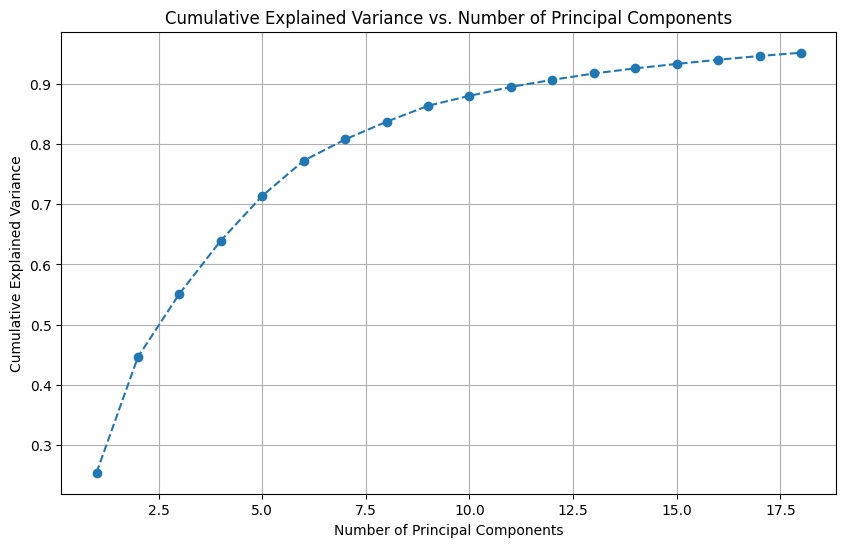

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_training_data = original_testing_data.iloc[:, 1:] 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_training_data)
scaled_data = pd.DataFrame(scaled_data, columns=original_training_data.columns[1:-6])
pca = PCA()

pca.fit(scaled_data)

pca_data = pca.transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

variance_threshold = 0.95
n_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
print(f"Number of components to retain {variance_threshold * 100}% variance: {n_components}")

pca = PCA(n_components=n_components)
pca_reduced_data = pca.fit_transform(scaled_data)

print(f"Reduced data shape: {pca_reduced_data.shape}")

loadings = pd.DataFrame(pca.components_, columns=pca_training_data.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
pc1_loadings = loadings.loc['PC1'].abs()

important_features_pc1 = pc1_loadings.sort_values(ascending=False)
print("Important features for PC1:")
print(important_features_pc1.to_string())


explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()



# Data Preprocessing Functions

In [65]:
def log_transform_data(data):

    log_transformed_data = np.log10(data + LOG_EPSILON)
    nan_mask = np.isnan(log_transformed_data)
    if log_transformed_data.isnull().values.any():
        nan_indices = np.argwhere(nan_mask)
        print("NaN indices in log_transformed_data:")
        print(nan_indices)
        size = 0

        for idx in nan_indices:
            row, col = idx
            print(f"NaN at row {row}, column '{log_transformed_data.columns[col]}': original value = {log_transformed_data.iloc[row, col]}")
            size += 1
        print(size)

        raise Exception("log is getting value close to 0")
    
    return log_transformed_data

def remove_outliers(data):
    first_column = data.iloc[:, 0]
    intermediate_columns = data.iloc[:, 1:-6]
    labels = data.iloc[:, -6:]

    mean = np.mean(labels, axis=0)
    std_dev = np.std(labels, axis=0)

    lower_threshold = mean - 3 * std_dev
    upper_threshold = mean + 3 * std_dev
    mask = (labels >= lower_threshold).all(axis=1) & (labels <= upper_threshold).all(axis=1)
    filtered_remaining_columns = labels[mask]

    result = pd.concat([first_column[mask], intermediate_columns[mask], filtered_remaining_columns], axis=1)

    return result

In [66]:
class PlantDataset(Dataset):
    def __init__(self, image_dir, ids, input_data, transform, labels=None, n_components=N_PCA_COMPONENTS):
        self.image_dir = image_dir
        self.ids = ids
        scaled_input = standard_scaler.fit_transform(input_data)
        self.pca_df = PCA(n_components=n_components).fit_transform(scaled_input)
        self.labels=labels
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        id_name = str(self.ids.iloc[idx])
        img_name = os.path.join(self.image_dir,  id_name + ".jpeg")
        image = self.transform(Image.open(img_name))
        input_data = self.pca_df[idx, :].astype('f')


        if self.labels is None:
            return image, input_data, id_name
        else:
            label_data = self.labels[idx, :].astype('f')
            return image, input_data, label_data

In [67]:
training_data_without_outliers = remove_outliers(original_training_data)
training_data_input = training_data_without_outliers.iloc[:, :-6]
training_data_labels = training_data_without_outliers.iloc[:, -6:]

training_input, validation_input, training_labels, validation_labels = train_test_split(training_data_input, training_data_labels, test_size=0.2, random_state=42)

In [68]:
training_data_ids = training_input.iloc[:, 0]
training_data_features = training_input.iloc[:, 1:-6]

log_training_labels = log_transform_data(training_labels)
scaled_training_labels = min_max_scaler.fit_transform(log_training_labels)

In [69]:
validation_data_ids = validation_input.iloc[:, 0]
validation_data_features = validation_input.iloc[:, 1:-6]

log_validation_labels = log_transform_data(validation_labels)
scaled_validation_labels = min_max_scaler.fit_transform(log_validation_labels)

In [70]:
testing_data = original_testing_data.copy(deep=True)
testing_data_ids = testing_data.iloc[:, 0]
testing_data_input_data = testing_data.iloc[:, 1:]

In [71]:
training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),    
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4464, 0.4505, 0.3360], std=[0.1834, 0.1794, 0.1779])
])

testing_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4464, 0.4505, 0.3360], std=[0.1834, 0.1794, 0.1779])
])

In [72]:
train_dataset = PlantDataset(image_dir=PATH_TO_TRAINING_IMAGES, ids=training_data_ids, input_data=training_data_features, transform=training_transform, labels=scaled_training_labels)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [73]:
val_dataset = PlantDataset(image_dir=PATH_TO_TRAINING_IMAGES, ids=validation_data_ids, input_data=validation_data_features, transform=testing_transform, labels=scaled_validation_labels)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [74]:
test_dataset = PlantDataset(image_dir=PATH_TO_TEST_IMAGES, ids=testing_data_ids, input_data=testing_data_input_data, transform=testing_transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Neural Network

### Class

In [75]:
class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18, self).__init__()

        # weights = ResNet18_Weights.DEFAULT
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 512)

        self.num_fc1 = nn.Linear(N_PCA_COMPONENTS, 256)
        self.num_fc2 = nn.Linear(256, 512)

        self.combined_fc1 = nn.Linear(512 + 512, 256)
        # self.combined_fc2 = nn.Linear(4096, 4096)
        self.combined_fc3 = nn.Linear(256, 6)

    def forward(self, image_input, numerical_input):
        x_img = self.resnet18(image_input)

        x_num = F.relu(self.num_fc1(numerical_input))
        x_num = F.relu(self.num_fc2(x_num))
        
        x_combined = torch.cat((x_img, x_num), dim=1)
        x_combined = F.relu(self.combined_fc1(x_combined))
        # x_combined = F.relu(self.combined_fc2(x_combined))
        output = self.combined_fc3(x_combined)

        return output

### Training Loop

In [76]:
model = ResNet18().to(device)
prev_r2_values = torch.asarray([0.192306, 0.469201, 0.815276, 0.854920, 0.183519, 0.784483]).to(device)
training_accuracy = {}
training_loss = {}
validation_accuracy = {}

for i in range(20):
    training_accuracy[i + 1] = []
    training_loss[i + 1] = []
    validation_accuracy[i + 1] = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)
ss_tot_training = np.sum((scaled_training_labels - np.mean(scaled_training_labels, axis=0)) ** 2, axis=0)
ss_tot_val = np.sum((scaled_validation_labels - np.mean(scaled_validation_labels, axis=0)) ** 2, axis=0)
best_r2 = float('-inf')
model_name = "24_pca_validation.pth"
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
print(ss_tot_training)
print(ss_tot_val)
for epoch in range(20):
    running_loss = 0.0
    ss_res_training = np.zeros(6)
    model.train()
    for batch_idx, (images, numerical_data, labels) in enumerate(train_data_loader):
        images, numerical_data, labels = images.to(device), numerical_data.to(device), labels.to(device)
        outputs = model(images, numerical_data)
        if torch.isnan(outputs).any():
            raise Exception("Something went wrong in Preprocessing")
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ss_res_training += torch.sum((labels - outputs.detach()) ** 2, axis=0).cpu().numpy()

        running_loss += loss.item()

        if  batch_idx % 16 == 15:
            training_loss[epoch + 1].append(running_loss)
            print(f'[{epoch + 1}, {batch_idx + 1:3d}] loss: {running_loss :.4f}')
    
    print(f'Epoch {epoch + 1} Training R^2:')
    training_R_2 = 1- (ss_res_training/ss_tot_training)
    training_avg_R_2 = np.mean(training_R_2)
    print(training_R_2)
    print("Average: ", training_avg_R_2)

    training_accuracy[epoch + 1].append(training_avg_R_2)

    model.eval()
    val_loss = 0.0
    val_ss_res = np.zeros(6)
    with torch.no_grad():
        for images, numerical_data, labels in val_data_loader:
            images, numerical_data, labels = images.to(device), numerical_data.to(device), labels.to(device)
            outputs = model(images, numerical_data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_ss_res += torch.sum((labels - outputs.detach()) ** 2, axis=0).cpu().numpy()

    val_R_2 = 1 - (val_ss_res / ss_tot_val)
    val_average_R_2 = np.mean(val_R_2)
    
    validation_accuracy[epoch + 1].append(val_average_R_2)
    
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss:.4f}')
    print(f'Epoch {epoch + 1} Validation R^2:')
    print(val_R_2)
    print("Average: ", val_average_R_2)

    scheduler.step()

    if val_average_R_2 > best_r2:
        torch.save(model.state_dict(), PATH_TO_MODEL + rf"\{model_name}")
        print("saved")
        best_r2 = val_average_R_2
print("done")

[ 863.22331389 1069.36567369 1151.04659172  524.71355389  860.20448088
 1015.76678586]
[236.48549266 277.0404989  296.64298033 137.34821853 234.46850059
 262.64172361]
[1,  16] loss: 1.1584
[1,  32] loss: 1.5898
[1,  48] loss: 2.0060
[1,  64] loss: 2.4042
[1,  80] loss: 2.8116
[1,  96] loss: 3.2043
[1, 112] loss: 3.6038
Epoch 1 Training R^2:
[-0.59928369 -0.00687687  0.16487128 -0.03701334 -0.16376946  0.03817726]
Average:  -0.10064913771214355
Epoch 1 Validation Loss: 0.8670
Epoch 1 Validation R^2:
[0.11021172 0.14740867 0.09116616 0.01913024 0.09461967 0.02985972]
Average:  0.0820660321280019
saved
[2,  16] loss: 0.3995
[2,  32] loss: 0.7716
[2,  48] loss: 1.1500
[2,  64] loss: 1.5270
[2,  80] loss: 1.8966
[2,  96] loss: 2.2823
[2, 112] loss: 2.6713
Epoch 2 Training R^2:
[0.1317416  0.17083248 0.29254548 0.09778303 0.07726546 0.22112931]
Average:  0.16521622505708314
Epoch 2 Validation Loss: 0.8571
Epoch 2 Validation R^2:
[ 0.10416243  0.16422978  0.13114745 -0.01789379  0.10017487  

### Visualising Data

In [4]:
def extend_lists(data_dict, x_list, y_list):
    for i in range(1, 21):
        curr_y = data_dict[i]
        curr_x = np.linspace(i-1, i, len(curr_y) + 1)
        curr_x = list(curr_x[1:])
        x_list.extend(curr_x)
        y_list.extend(curr_y)

training_accuracy_x = []
training_accuracy_y = []
training_loss_x = []
training_loss_y = []
validation_accuracy_x = []
validation_accuracy_y = []
extend_lists(training_accuracy, training_accuracy_x, training_accuracy_y)
extend_lists(training_loss, training_loss_x, training_loss_y)
extend_lists(validation_accuracy, validation_accuracy_x, validation_accuracy_y)


b = px.scatter(x=training_accuracy_x, y=training_accuracy_y, 
                 labels={"y": "R2", 
                         "x": "Epoch (int. values are mini-batches)"}, 
                 title="Training R2 versus Epoch")
b.update_layout(showlegend=False)
b.show()

c = px.scatter(x=training_loss_x, y=training_loss_y, 
                 labels={"y": "Training Loss", 
                         "x": "Epoch (int. values are mini-batches)"}, 
                 title="Training Loss versus Epoch")
c.update_layout(showlegend=False)
c.show()

a = px.scatter(x=validation_accuracy_x, y=validation_accuracy_y, 
                 labels={"y": "R2", 
                         "x": "Epoch (int. values are mini-batches)"}, 
                 title="Validation R2 versus Epoch")
a.update_layout(showlegend=False)
a.show()



### Testing Loop

In [62]:
model = ResNet18().to(device)
model.load_state_dict(torch.load(PATH_TO_MODEL + rf"\{model_name}", weights_only=True))
best_r2

0.1850609780976089

In [63]:
def inverse_log_transform(data):
    return 10 ** data - LOG_EPSILON

model.eval()
predictions = []
identifiers = []
nans = 0
with torch.no_grad():
    for images, numerical_data, ids in test_data_loader:
        images, numerical_data = images.to(device), numerical_data.to(device)
        outputs = model(images, numerical_data)
        outputs_cpu = outputs.cpu().numpy()
        unscaled_output = min_max_scaler.inverse_transform(outputs_cpu)
        output_prediction = inverse_log_transform(unscaled_output)
        if np.isnan(output_prediction).any(): nans += 1
        if torch.isnan(outputs).any(): nans += 1
        predictions.extend(output_prediction)
        identifiers.extend(ids)
print("nans", nans)
df = pd.DataFrame(predictions, columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
df['id'] = identifiers  # Add identifiers to DataFrame
df = df[['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']]
df.to_csv(PATH_TO_OUTPUT_CSV + r"\Predictions\final_pca_p30_least_regularization.csv", index=False)

nans 0
